In [1]:
# prompt: mount drive
import os
import pandas as pd
import re
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/

Mounted at /content/drive
/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria


In [2]:
path_silicio = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/Si_445"
path_vidrio = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/vidrio_2"
path_aire = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/aire_v2"
path_aire = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/aire_2_v2"
path_sustrato = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/sustrato"
path_Si = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/datos/Si.txt"
path_O2Si = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/datos/O2Si.txt"
path_BK7 = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/datos/N-BK7.txt"
path_air = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/datos/Ciddor.txt"
path_ag = "/content/drive/MyDrive/Colab/materiales/MaterialesElipsometria/datos/Johnson.txt"

# Funciones

### Secundarias

In [3]:
def arctan3(y,x):
  return np.mod(np.arctan2(y,x),2*np.pi)-5/4*np.pi

In [4]:
def calcular_indice_refraccion(dataset):
  n = dataset['n']
  if 'k' in dataset:
    n = n + complex(0,1) * dataset['k']
  return n

In [5]:
def calcular_stokes(I0, I45, I90, I135):
  #Stokes
  S0 = I0 + I90
  S1 = I0 - I90
  S2 = I45 - I135
  return S0, S1, S2

In [6]:
def evaluar_funcion(funcion, name, wavelength, LongitudOnda, verbose = False):

  #Número de muestra
  N = obtener_muestra(wavelength, LongitudOnda)

  if verbose:
    print(name + ' a ' + str(int(LongitudOnda)) + ' nm:', funcion[N])

  return funcion[N], wavelength[N]

In [7]:
def crear_lista_angulos(angulo_incial, angulo_final, angulo_paso):
  #Angulos de incidencia
  theta_0_str = []
  num = float(angulo_incial)
  while num <= angulo_final:
    if num.is_integer():
      theta_0_str.append(str(int(num)))
    else:
      theta_0_str.append(str(num))
    num += angulo_paso
  return theta_0_str

In [8]:
def obtener_muestra(wavelength, LongitudOnda):

  # Find the index of the closest value to 450
  closest_index = np.argmin(np.abs(wavelength - LongitudOnda))

  # Get the value at the closest index
  closest_value = wavelength[closest_index]

  #Longitud de Onda muestra
  N = np.where(wavelength == closest_value)[0][0]

  return N

In [9]:
def interpolar_dataframe(df, wl_inicial = 300, wl_final = 800, wl_paso = 1):
  # Crear un nuevo rango de longitudes de onda
  wl = np.arange(wl_inicial, wl_final, wl_paso)

  # Inicializar un nuevo DataFrame
  df_int = pd.DataFrame({'wl': wl})

  # Interpolar linealmente los valores de 'n' y 'k'
  df_int['n'] = np.interp(wl, df['wl'], df['n'])

  #Si hay absorción interpolar
  if 'k' in df.columns:
    df_int['k'] = np.interp(wl, df['wl'], df['k'])

  return df_int

In [10]:
def cargar_data(path):
  with open(path, 'r') as f:
    lines = f.readlines()

  if '\n' in lines:
    # Encuentra el índice de la línea en blanco
    blank_line_index = lines.index('\n')

    # Datos antes de la línea en blanco
    data1 = lines[:blank_line_index]

    # Datos después de la línea en blanco
    data2 = lines[blank_line_index + 1:]

    # Leer líneas de texto
    data1_split = [line.strip().split() for line in data1[1:]]
    data2_split = [line.strip().split() for line in data2[1:]]

    # Crear dataframe
    df1 = pd.DataFrame(np.array(data1_split).astype(float), columns = ['wl', 'n'])
    df2 = pd.DataFrame(np.array(data2_split).astype(float), columns = ['wl', 'k'])
    df = pd.concat([df1, df2['k']], axis=1)

    #Convertir a nanometros
    df['wl'] = df['wl'] * 1000

  else:
    #Si no hay línea en blanco
    data1 = lines
    data1_split = [line.strip().split() for line in data1[1:]]
    df = pd.DataFrame(np.array(data1_split).astype(float), columns = ['wl', 'n'])
    df['wl'] = df['wl'] * 1000

  return df

In [11]:
def calculo_psi_delta_experimental(I0, I45, I90, I135, saturar):

  #Psi
  argumento_psi = (I90-I0)/(I90+I0)
  if saturar:
    argumento_psi[argumento_psi < -1] = -1
    argumento_psi[argumento_psi > 1] = 1

  psi = 0.5*np.arccos(argumento_psi)

  #Delta
  argumento_delta = ((I45-I135)/(I45+I135)) / np.sin(2*psi)

  #Valores fuera de rango
  if saturar:
    argumento_delta[argumento_delta < -1] = -1
    argumento_delta[argumento_delta > 1] = 1

  delta = np.arccos(argumento_delta)

  return psi, delta

In [12]:
def cargar_intensidades(dataset, theta, angulo_calibracion):

  #Intensidades
  I0 = dataset[theta]['transmitance 0']
  I45 = dataset[theta]['transmitance 45']
  I90 = dataset[theta]['transmitance 90']
  I135 = dataset[theta]['transmitance 135']

  #Pasar a radianes
  angulo_calibracion = angulo_calibracion * np.pi / 180

  #Calcular Stokes
  S0, S1, S2 = calcular_stokes(I0, I45, I90, I135)

  #Stokes calibrado
  S1_rot = np.cos(2*angulo_calibracion) * S1 + np.sin(2*angulo_calibracion) * S2
  S2_rot = -np.sin(2*angulo_calibracion) * S1 + np.cos(2*angulo_calibracion) * S2

  #Intensidades
  I0 = 0.5*(S0 + S1_rot)
  I45 = 0.5*(S0 + S2_rot)
  I90 = 0.5*(S0 - S1_rot)
  I135 = 0.5*(S0 - S2_rot)

  return I0, I45, I90, I135

In [13]:
def plot_intensidades(I, wavelength):
  #Crear Figura
  fig, axes = plt.subplots(2, 2, figsize=(10, 10))

  #Mostrar cada espectro polarizado
  angulos = ['0', '45', '90', '135']

  #Limite Ylim
  Ylim = 0
  for i, angulo in enumerate(angulos):
    Ylim = max(Ylim, np.max(I[i]))

   # Plot the data in the subplot
  for i, angulo in enumerate(angulos):
    axes[i // 2, i % 2].plot(wavelength, I[i]/Ylim)
    axes[i // 2, i % 2].set_xlabel('Longitud de Onda (nm)')
    axes[i // 2, i % 2].set_ylabel('Intensidad (u.a.)')
    axes[i // 2, i % 2].set_title('Ángulo Analizador = ' + angulo + 'º')
    axes[i // 2, i % 2].set_ylim(0, 1)

  # Adjust spacing and display
  plt.tight_layout()
  plt.show()

  return None

In [14]:
#Plot angular
def plot_angular(LongitudOnda, wl_range_teorico, wl_range_experimental, theta_0_teorico, theta_0_experimental, medida1_teorico, medida2_teorico, medidad1_experimental, medidad2_experimental, titulo, tipo, linestyle, teorico, experimental):

  if tipo == 'psi_delta':

    #Numero de muestra
    N_teorico = obtener_muestra(wl_range_teorico, LongitudOnda)
    N_experimental = obtener_muestra(wl_range_experimental, LongitudOnda)

    # Plot psi and delta in degrees
    plt.figure(figsize=(12, 6))
    if teorico == True:
      plt.plot(theta_0_teorico, medida1_teorico[:,N_teorico], linestyle = linestyle, label = r'$\Psi$ Teórico')
      plt.plot(theta_0_teorico, medida2_teorico[:,N_teorico] , linestyle = linestyle, label = r'$\Delta$ Teórico')
    if experimental == True:
      plt.plot(theta_0_experimental, medidad1_experimental[:,N_experimental], 's', label = r'$\Psi$ Experimental')
      plt.plot(theta_0_experimental, medidad2_experimental[:,N_experimental], 's', label = r'$\Delta$ Experimental')
    plt.xlabel(r'$\theta_0$ (º)')
    plt.ylabel(r'$\Psi, \Delta$ (º)')
    plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\lambda$=' + str(LongitudOnda) + ' nm')
    plt.xlim([0, 90])
    plt.ylim([-10, 190])
    plt.xticks(np.arange(0,95,5))
    plt.yticks(np.arange(0,190,10))
    plt.legend()
    plt.show()

  elif tipo == 'rp_rs':

    #Numero de muestra
    N_teorico = obtener_muestra(wl_range_teorico, LongitudOnda)
    N_experimental = obtener_muestra(wl_range_experimental, LongitudOnda)

    # Plot psi and delta in degrees
    plt.figure(figsize=(12, 6))
    if teorico == True:
      plt.plot(theta_0_teorico, medida1_teorico[:,N_teorico], linestyle = linestyle, label = r'$R_s$ Teórico')
      plt.plot(theta_0_teorico, medida2_teorico[:,N_teorico] , linestyle = linestyle, label = r'$R_p$ Teórico')
    if experimental == True:
      plt.plot(theta_0_experimental, medidad1_experimental[:,N_experimental], 's', label = r'$R_s$ Experimental')
      plt.plot(theta_0_experimental, medidad2_experimental[:,N_experimental], 's', label = r'$R_p$ Experimental')
    plt.xlabel(r'$\theta_0$ (º)')
    plt.ylabel(r'$R_s, R_p$')
    plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\lambda$=' + str(LongitudOnda) + ' nm')
    plt.xlim([0, 90])
    plt.ylim([0, 1.05])
    plt.xticks(np.arange(0,95,5))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()
    plt.show()

  return None

In [15]:
#Plot angular
def plot_espectral(AnguloIncidencia, wl_range_teorico, wl_range_experimental, theta_0_teorico, theta_0_experimental, medida1_teorico, medida2_teorico, medidad1_experimental, medidad2_experimental, titulo, tipo, linestyle, teorico, experimental):

  if tipo == 'psi_delta':

    #Numero de muestra
    N_teorico = obtener_muestra(theta_0_teorico, AnguloIncidencia)
    N_experimental = obtener_muestra(theta_0_experimental, AnguloIncidencia)

    # Plot psi and delta in degrees
    plt.figure(figsize=(12, 6))
    if teorico == True:
      plt.plot(wl_range_teorico, psi_teorico[N_teorico,:], linestyle = linestyle, label = r'$\Psi$ Teórico')
      plt.plot(wl_range_teorico, delta_teorico[N_teorico,:] , linestyle = linestyle, label = r'$\Delta$ Teórico')
    if experimental == True:
      plt.plot(wl_range_experimental, psi_experimental[N_experimental,:], '', label = r'$\Psi$ Experimental')
      plt.plot(wl_range_experimental, delta_experimental[N_experimental,:], '', label = r'$\Delta$ Experimental')
    plt.xlabel(r'$\lambda$ (nm)')
    plt.ylabel(r'$\Psi, \Delta$ (º)')
    plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\Theta$=' + str(AnguloIncidencia) + ' º')
    plt.xlim([wl_min, wl_max])
    plt.ylim([-10, 190])
    plt.xticks(np.arange(wl_min,wl_max,int((wl_max-wl_min)/20)))
    plt.yticks(np.arange(0,190,10))
    plt.legend()
    plt.show()

  elif tipo == 'rp_rs':

    #Numero de muestra
    N_teorico = obtener_muestra(theta_0_teorico, AnguloIncidencia)
    N_experimental = obtener_muestra(theta_0_experimental, AnguloIncidencia)

    # Plot psi and delta in degrees
    plt.figure(figsize=(12, 6))
    if teorico == True:
      plt.plot(wl_range_teorico, Rs_teorico[N_teorico,:], '', label = r'$R_s$ Teórico')
      plt.plot(wl_range_teorico, Rp_teorico[N_teorico,:], '', label = r'$R_p$ Teórico')
    if experimental == True:
      plt.plot(wl_range_experimental, Rs_experimental[N_experimental,:], '', label = r'$R_s$ Experimental')
      plt.plot(wl_range_experimental, Rp_experimental[N_experimental,:], '', label = r'$R_p$ Experimental')
    plt.xlabel(r'$\lambda$ (nm)')
    plt.ylabel(r'$R_s, R_p$')
    plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\Theta$=' + str(AnguloIncidencia) + 'º')
    plt.xlim([wl_min, wl_max])
    plt.ylim([0, 1.05])
    plt.xticks(np.arange(wl_min,wl_max,int((wl_max-wl_min)/20)))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()
    plt.show()

  return None

In [16]:
def plot_dolp_aolp(DoLP, AoLP, wavelength):

  #AoLP a grados
  AoLP = AoLP * 180 / np.pi

  #Figuras
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  #DoLP
  axes[0].plot(wavelength, DoLP)
  axes[0].set_xlabel('Longitud de Onda (nm)')
  axes[0].set_ylabel('Grado de Polarización Lineal')
  #axes[0].set_xlim(400, 900)
  axes[0].set_ylim(0, 2)
  axes[0].axhline(y=1, color='k', linestyle='--', linewidth=1)
  axes[0].axhline(y=1+0.05, color='r', linestyle='--', linewidth=1)
  axes[0].axhline(y=1-0.05, color='r', linestyle='--', linewidth=1)
  axes[0].set_title('Espectro DoLP')

  #AoLP
  axes[1].plot(wavelength, AoLP)
  axes[1].set_xlabel('Longitud de Onda (nm)')
  axes[1].set_ylabel('Ángulo de Polarización Lineal (º)')
 # axes[1].set_xlim(400, 900)
  axes[1].set_ylim(0, 180)
  axes[1].set_title('Espectro AoLP')

  #0
  axes[1].axhline(y=0/4*180, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=0/4*180+180*0.05, color='r', linestyle='--', linewidth=1)

  #45
  axes[1].axhline(y=1/4*180, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=1/4*180+180*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=1/4*180-180*0.05, color='r', linestyle='--', linewidth=1)

  #90
  axes[1].axhline(y=2/4*180, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=2/4*180+180*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=2/4*180-180*0.05, color='r', linestyle='--', linewidth=1)

  #135
  axes[1].axhline(y=3/4*180, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=3/4*180+180*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=3/4*180-180*0.05, color='r', linestyle='--', linewidth=1)

  #180
  axes[1].axhline(y=4/4*180, color='k', linestyle='--', linewidth=1)
  axes[1].axhline(y=4/4*180+180*0.05, color='r', linestyle='--', linewidth=1)
  axes[1].axhline(y=4/4*180-180*0.05, color='r', linestyle='--', linewidth=1)

  # Adjust spacing and display
  plt.tight_layout()
  plt.show()

  return None

### Principales

In [63]:
def calculo_experimental(dataset_in, dataset_out, angulo_calibracion_in = 0, angulo_calibracion_out = 0, angulo_incial = 15, angulo_final = 75, angulo_paso = 2.5, saturar = False):

  #Lista de ángulos
  theta_0_str = crear_lista_angulos(angulo_incial, angulo_final, angulo_paso)

  #Angulos de polarización
  angulos = ['0', '45', '90', '135']

  #Longitud de Onda
  wl_range = np.array(dataset_out[theta_0_str[0]]['wavelength'])

  #Entrada
  I_in_p, I45, I_in_s, I135 = cargar_intensidades(dataset_in, '90', angulo_calibracion = angulo_calibracion_in)

  # Salida
  Psi =  np.zeros((len(theta_0_str), len(wl_range)))
  Delta = np.zeros((len(theta_0_str), len(wl_range)))
  Rp = np.zeros((len(theta_0_str), len(wl_range)))
  Rs = np.zeros((len(theta_0_str), len(wl_range)))

  for i, theta in enumerate(theta_0_str):

    #Salida
    I0, I45, I90, I135 = cargar_intensidades(dataset, theta, angulo_calibracion = angulo_calibracion_out)

    #Calculo psi, Delta
    Psi[i,:], Delta[i,:] = calculo_psi_delta_experimental(I0, I45, I90, I135, saturar = saturar)

    #Reflectancias
    I_out_p, I_out_s = I0, I90
    Rp[i,:], Rs[i,:] = I_out_p / I_in_p, I_out_s / I_in_s

  #Calibración
  Psi = Psi - angulo_calibracion_out * np.pi / 180

  #Pasa a grados
  Psi = Psi / np.pi * 180
  Delta = Delta / np.pi * 180
  theta_0 = np.array(theta_0_str).astype(float)

  return wl_range, theta_0, Psi, Delta, Rp, Rs

In [18]:
def calculo_teorico(dataset_n1, dataset_n2, d, angulo_incial = 15, angulo_final = 80, angulo_paso = 0.5, wl_inicial = 300, wl_final = 800, wl_paso = 1):

  #Longitud de onda
  wl_range = np.arange(wl_inicial, wl_final, wl_paso)

  #Angulo de incidencia
  theta_0 = np.arange(angulo_incial, angulo_final, angulo_paso) * np.pi / 180

  #Interpolación dataset
  dataset_n1 = interpolar_dataframe(dataset_n1, wl_inicial = wl_inicial, wl_final = wl_final)
  dataset_n2 = interpolar_dataframe(dataset_n2, wl_inicial = wl_inicial, wl_final = wl_final)

  #Cálculo de indices de refracción complejo
  n0 = 1
  n1_range = calcular_indice_refraccion(dataset_n1)
  n2_range = calcular_indice_refraccion(dataset_n2)

  # Salida
  Psi =  np.zeros((len(theta_0), len(wl_range)))
  Delta = np.zeros((len(theta_0), len(wl_range)))
  Rp = np.zeros((len(theta_0), len(wl_range)))
  Rs = np.zeros((len(theta_0), len(wl_range)))

  #Para cada longitud de onda
  for i, wl in enumerate(wl_range):

    #Indices de Refracción
    n1 = n1_range[i]
    n2 = n2_range[i]

    #Angulos de refracción y transmisión
    sin_theta_0 = np.sin(theta_0)
    cos_theta_0 = np.cos(theta_0)
    sin_theta_1 = (n0/n1) * sin_theta_0
    cos_theta_1 = np.sqrt(1 - sin_theta_1**2)
    sin_theta_2 = (n0/n2) * sin_theta_0
    cos_theta_2 = np.sqrt(1 - sin_theta_2**2)

    #Diferencia de fases
    beta = 2*np.pi/wl*d*n1*cos_theta_1

    #Indices de Reflectancia paralelo y perpendicular
    r01p = (n1*cos_theta_0 - n0*cos_theta_1) / (n1*cos_theta_0 + n0*cos_theta_1)
    r01s = (n0*cos_theta_0 - n1*cos_theta_1) / (n0*cos_theta_0 + n1*cos_theta_1)
    r12p = (n2*cos_theta_1 - n1*cos_theta_2) / (n2*cos_theta_1 + n1*cos_theta_2)
    r12s = (n1*cos_theta_1 - n2*cos_theta_2) / (n1*cos_theta_1 + n2*cos_theta_2)

    #Indices de Reflectancia total paralela y perpendicular
    r012p = (r01p + r12p*np.exp(-2*complex(0,1)*beta)) / (1 + r01p*r12p*np.exp(-2*complex(0,1)*beta))
    r012s = (r01s + r12s*np.exp(-2*complex(0,1)*beta)) / (1 + r01s*r12s*np.exp(-2*complex(0,1)*beta))

    #Reflectancias total paralela y perpendicular
    Rp[:,i] = np.abs(r012p)**2
    Rs[:,i] = np.abs(r012s)**2

    #Ley de Elipsometría
    P = r012p/r012s

    # Módulo y fase de P
    modulo_P = np.abs(P)
    fase_P = np.angle(P)

    # Definir delta y psi
    delta = fase_P
    delta[delta < 0] = -delta[delta < 0]
    psi = np.arctan(modulo_P)

    #Pasa a grados
    Psi[:,i] = psi * 180 / np.pi
    Delta[:,i] = delta * 180 / np.pi

  #Pasa a grados
  theta_0 = theta_0 * 180 / np.pi

  return wl_range, theta_0, Psi, Delta, Rp, Rs

In [19]:
def crear_dataset(path, verbose = False):

  #Dataset donde se guardará toda la información
  dataset = {}

  #cd Path
  os.chdir(path)

  #Lista de carpetas, cada una representando un ángulo del brazo
  folders = os.listdir(path)

  #Recorrer carpetas
  for folder in folders:

    #Unir rutas para acceder dentro de la carpeta ángulo del brazo
    folder_path = os.path.join(path, folder)

    #Recorrer archivos, cada uno representando un ángulo del analizador
    txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

    if os.path.isdir(folder_path):

      for i, file in enumerate(txt_files):

        #Imprimir Nombres
        if verbose:
          print(folder_path)
          print(file)

        #Abrir Archivo sólo donde interesa
        with open(folder + '/' + file, 'r') as f:
          lines = f.readlines()

          data_start = lines.index(">>>>>Begin Processed Spectral Data<<<<<\n") + 1
          data_end = lines.index(">>>>>End Processed Spectral Data<<<<<\n")

          data_lines = lines[data_start:data_end]

        # Extraer exposición
        line = next(line for line in lines if "Integration Time (usec):" in line)
        integration_time_str = re.search(r"Integration Time \(usec\): (\d+)\s*\(ADUD7991\)\n", line).group(1)
        integration_time = int(integration_time_str)
        print(integration_time)

        #Imprimir Tiempo de Integración
        if verbose:
          print("Integration Time (usec): ", integration_time)

        # Separar en dos columnas los datos
        wavelength, transmitance = [], []
        for line in data_lines:
          values = line.split('\t')
          wavelength.append(float(values[0]))
          transmitance.append(float(values[1]))

        #Agregar al dataset el conjunto de medidas
        df = pd.DataFrame({
            'wavelength': wavelength,
            'transmitance ' + file[:-4]: np.array(transmitance)/integration_time
        })

        #Si es el primero, copia el dataset
        if i == 0:
          dataset[folder] = df

        #Sino, agrega las demas transmitancias
        else:
          dataset[folder]['transmitance ' + file[:-4]] = df['transmitance ' + file[:-4]]

        if verbose:
          print('\n')

  return dataset

In [20]:
def mostrar_dataset(dataset, theta, angulo_calibracion = 0):

  #Tomar dato de ángulo brazo theta
  data = dataset[theta]

  #Cargar intensidades
  I0, I45, I90, I135 = cargar_intensidades(dataset, theta, angulo_calibracion)

  #Vector de Intensidades
  I = [I0, I45, I90, I135]

  #Calcular Stokes
  S0, S1, S2 = calcular_stokes(I0, I45, I90, I135)

  #DoLP y AoLP
  DoLP = np.divide(np.sqrt(np.power(S1.astype(float),2) + np.power(S2.astype(float),2)), S0, out = np.zeros_like(S0.astype(float)), where = S0!= 0)
  AoLP = 0.5*np.arctan2(S2.astype(float), S1.astype(float))

  #Eje horizontal
  wavelength = data['wavelength']

  #Plot intensidades
  plot_intensidades(I, wavelength)

  #Plot DoLP y AoLP
  plot_dolp_aolp(DoLP, AoLP, wavelength)

  #Evaluar función
  evaluar_funcion(DoLP, 'DoLP', wavelength, 500e-9)
  evaluar_funcion(AoLP * 180/np.pi, 'AoLP', wavelength, 500e-9)

# Silicio 445

In [21]:
dataset_silicio = crear_dataset(path_silicio)

100000
100000
100000
100000
45000
45000
45000
45000
30000
30000
30000
30000
30000
30000
30000
30000
75000
75000
75000
75000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
30000
70000
70000
70000
70000
8000
8000
8000
8000
30000
30000
30000
30000
4000
4000
4000
4000
4000
4000
4000
4000
30000
30000
30000
30000
8000
8000
8000
8000
30000
30000
30000
30000
8000
4000
4000
4000
4000
8000
8000
8000
8000
30000
30000
30000
30000
5000
5000
5000
5000
5000
5000
5000
5000
4000
4000
4000
4000
3000
3000
3000
3000
9000
9000
9000
9000


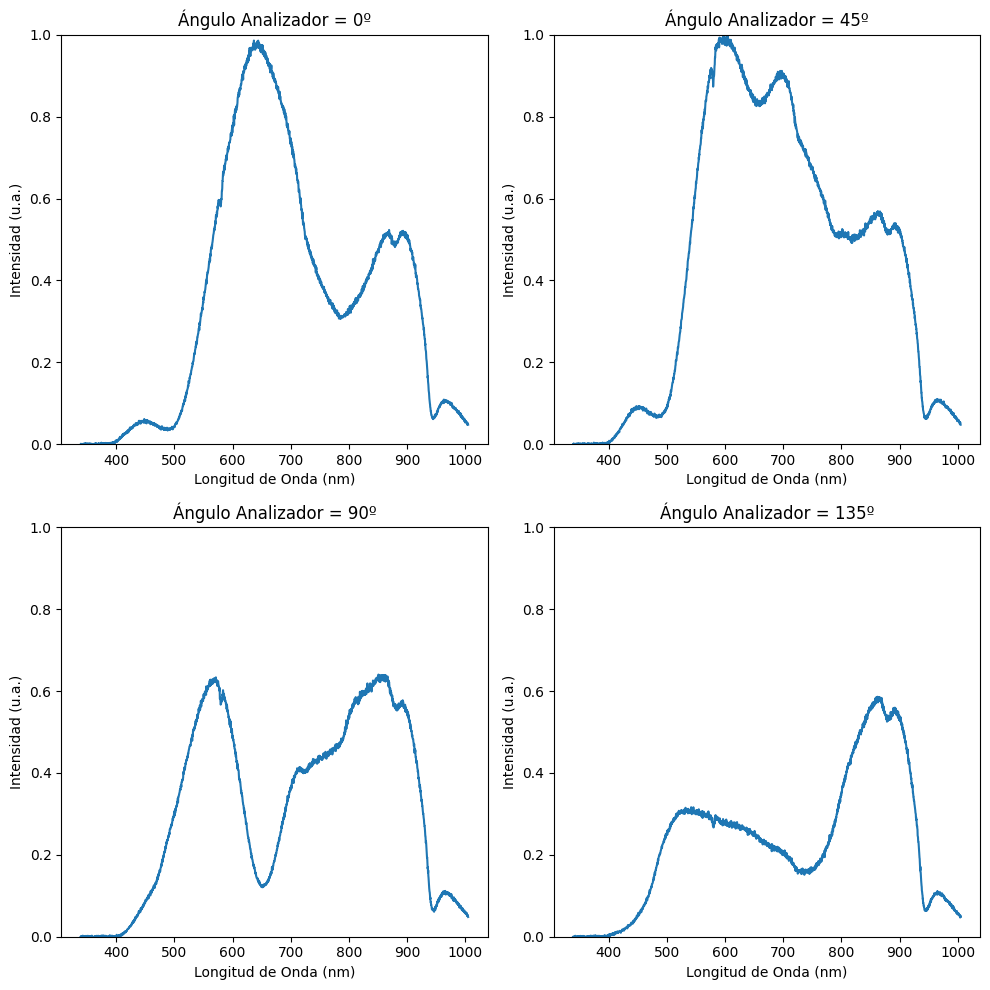

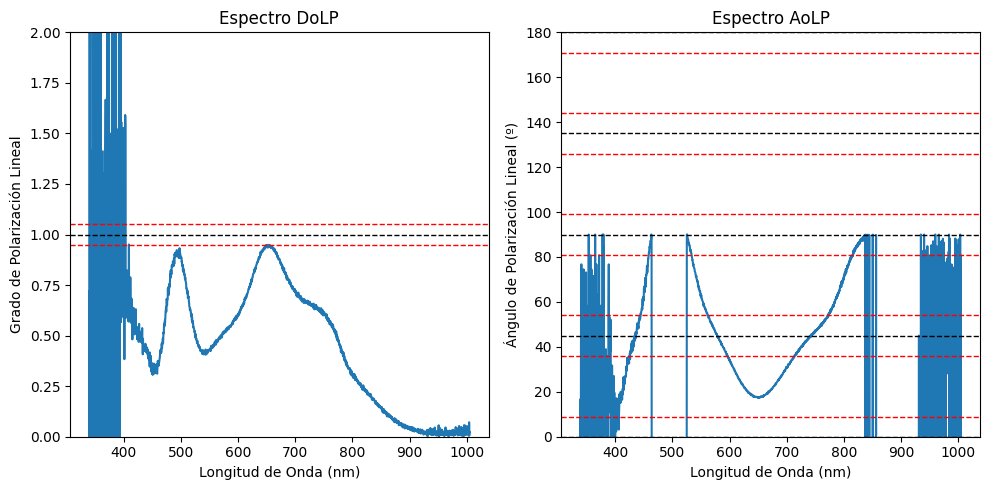

In [22]:
mostrar_dataset(dataset_silicio, '75')

# Vidrio

In [23]:
dataset_vidrio = crear_dataset(path_vidrio)

15000
15000
15000
15000
80000
80000
80000
80000
15000
15000
15000
15000
25000
25000
25000
25000
80000
80000
80000
80000
80000
80000
80000
80000
90000
90000
90000
80000
15000
15000
15000
15000
90000
90000
90000
90000
15000
15000
15000
15000
15000
15000
15000
15000
8000
8000
8000
8000
15000
15000
15000
15000


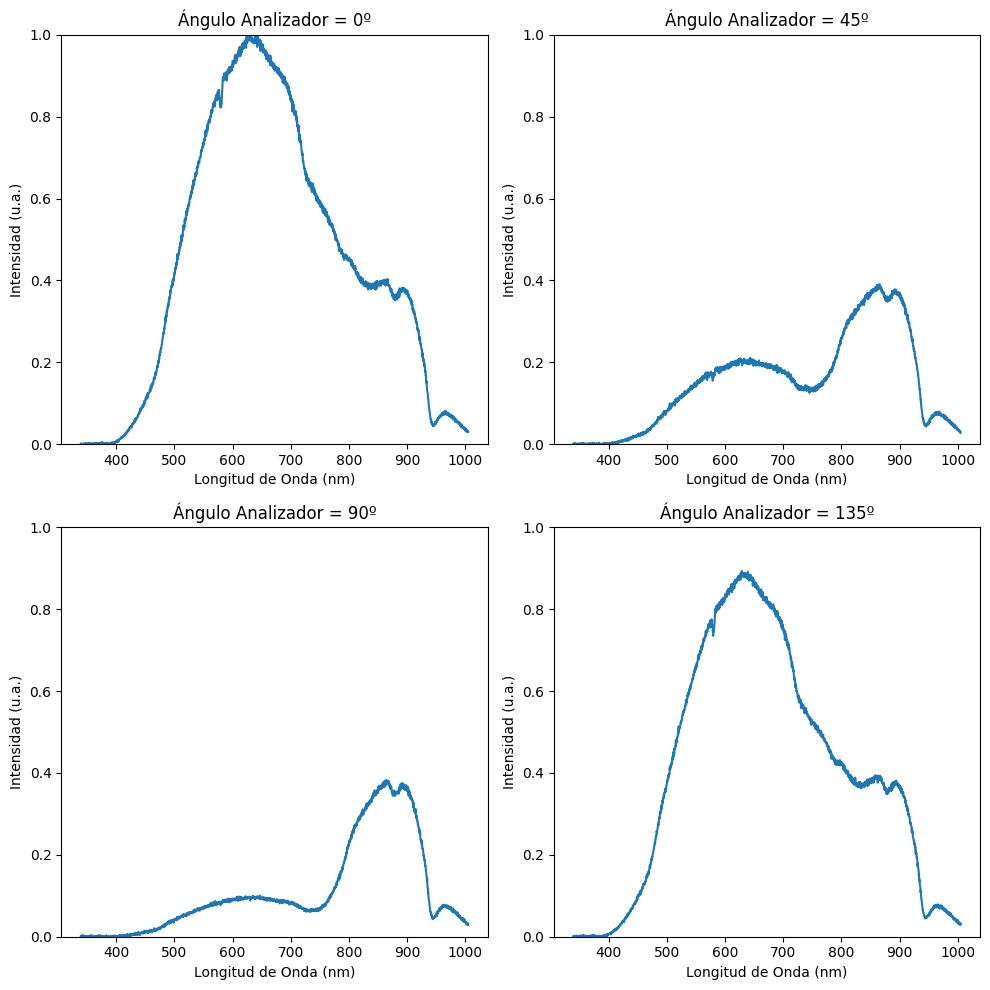

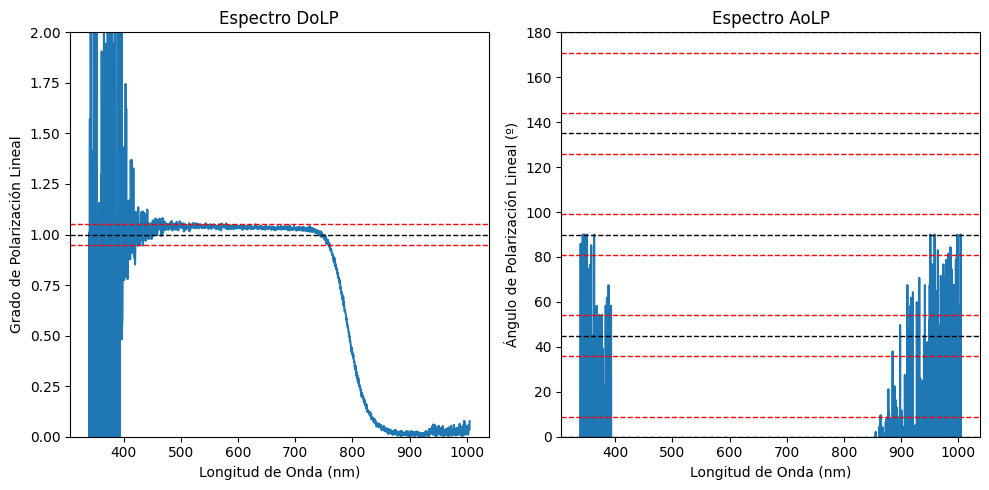

In [24]:
mostrar_dataset(dataset_vidrio, '15')

# Aire

In [25]:
dataset_aire = crear_dataset(path_aire)

40000
20000
20000
40000


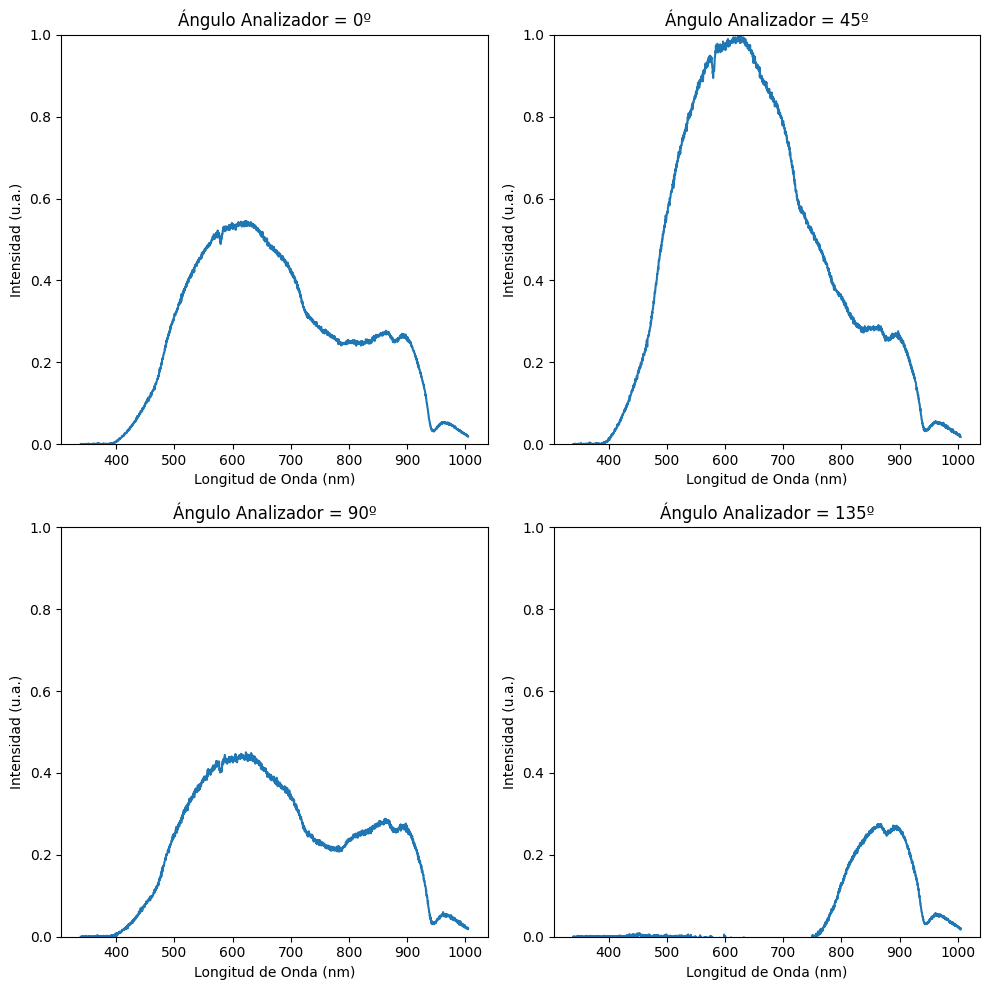

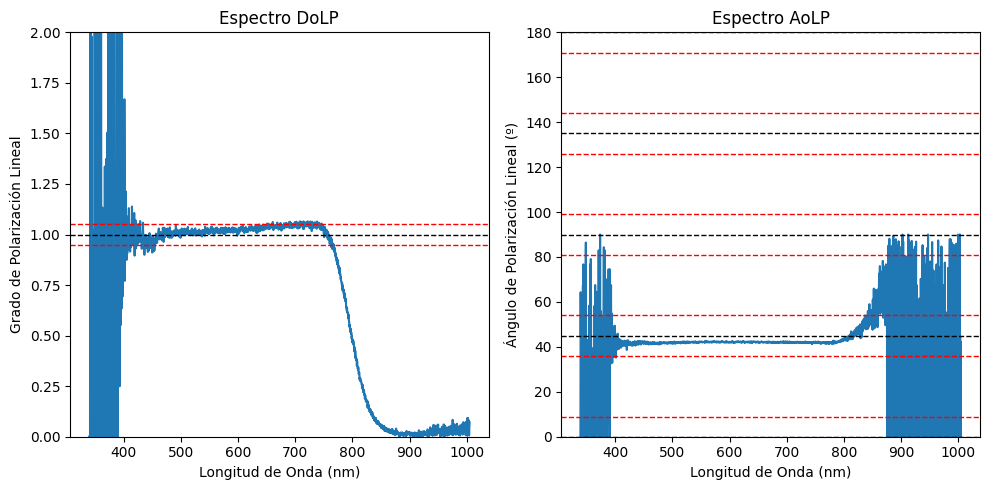

In [26]:
mostrar_dataset(dataset_aire, '90', angulo_calibracion = 0)

# Sustrato

In [ ]:
dataset_sustrato = crear_dataset(path_sustrato)

30000000
30000000
30000000
30000000
20000000
20000000
20000000
20000000
5000000
5000000
5000000
5000000


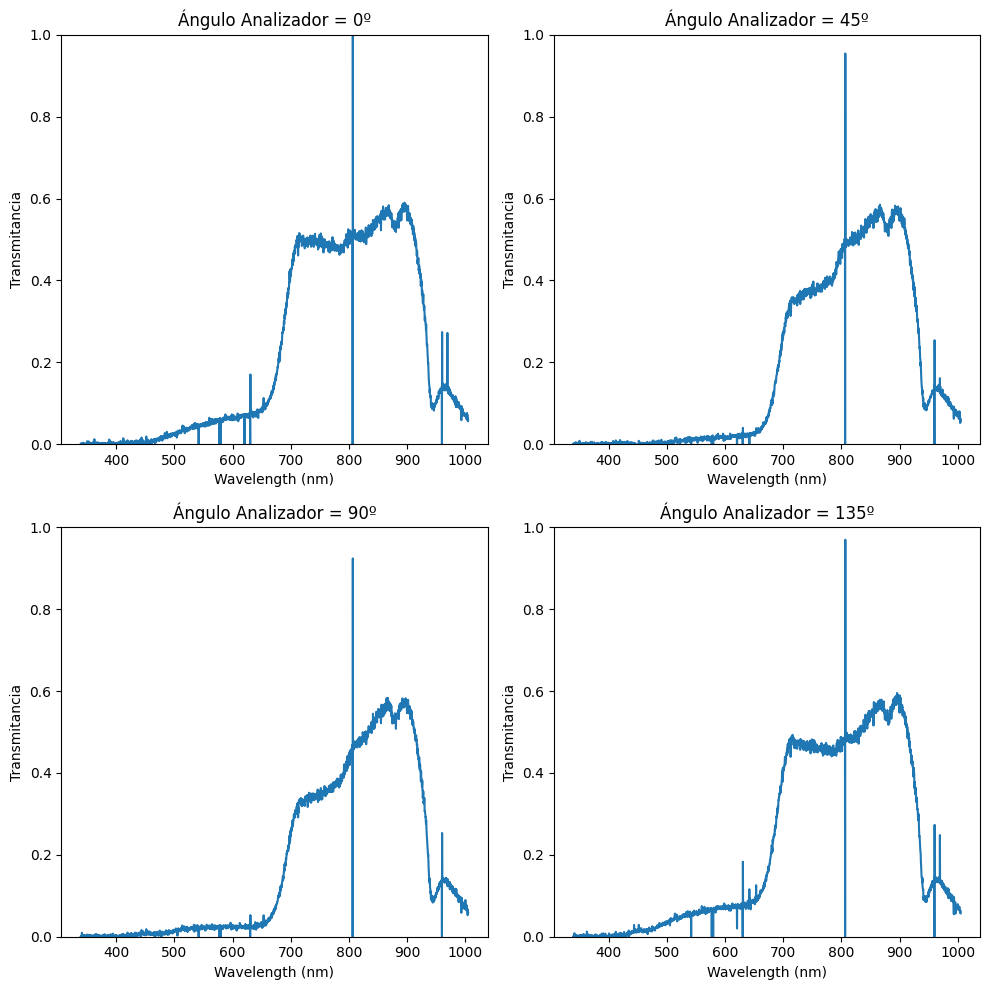

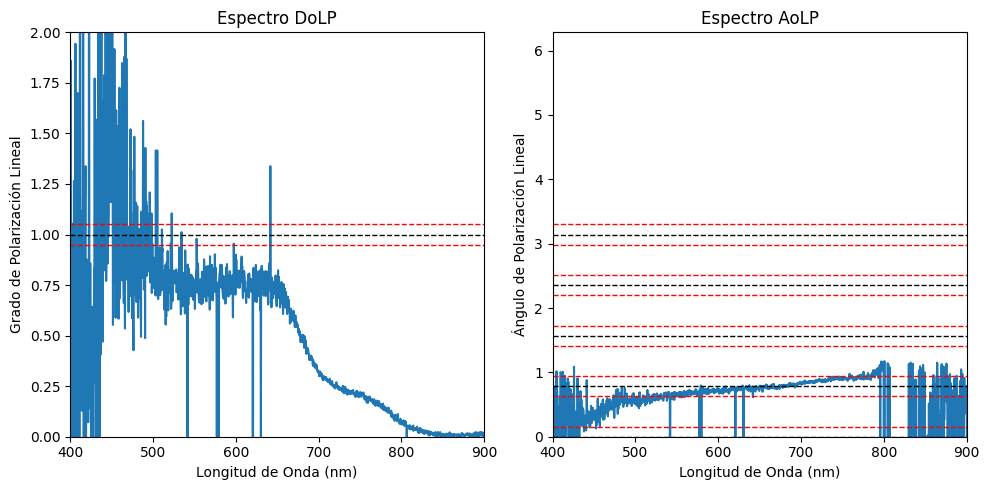

In [ ]:
mostrar_dataset(dataset_sustrato, '15')

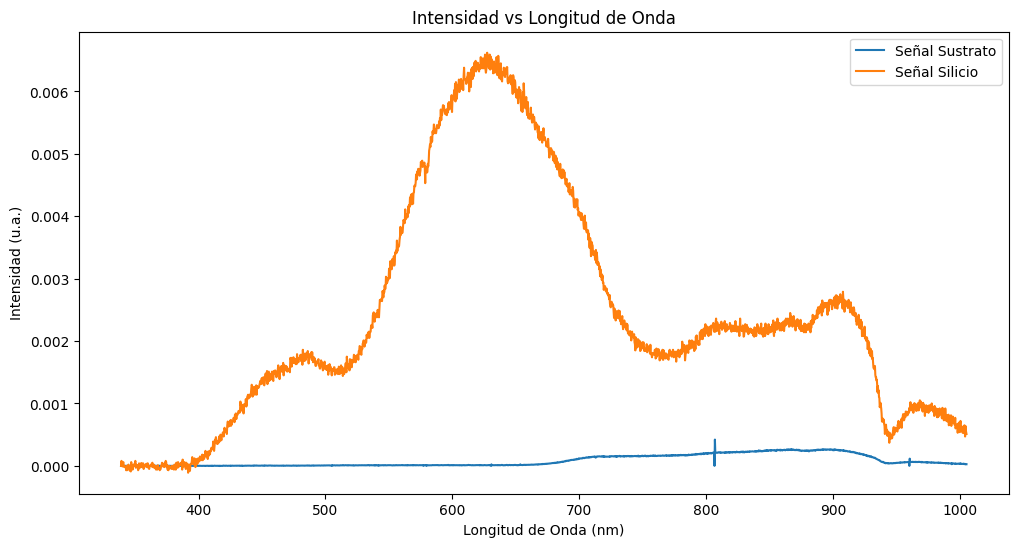

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dataset_sustrato['15']['wavelength'], 6*dataset_sustrato['15']['transmitance 90'], label = 'Señal Sustrato')
plt.plot(dataset_silicio['15']['wavelength'], dataset_silicio['15']['transmitance 45'], label = 'Señal Silicio')
plt.xlabel('Longitud de Onda (nm)')
plt.ylabel('Intensidad (u.a.)')
plt.title('Intensidad vs Longitud de Onda')
plt.legend()
plt.show()

# Curvas Δ, Ψ del Silicio

In [162]:
#Parámetros Silicio
d = 445
titulo = 'Silicio'
df_O2Si = cargar_data(path_O2Si)
df_Si = cargar_data(path_Si)
dataset = dataset_silicio
angulo_paso = 2.5
df_1 = df_O2Si
df_2 = df_Si
teorico = True

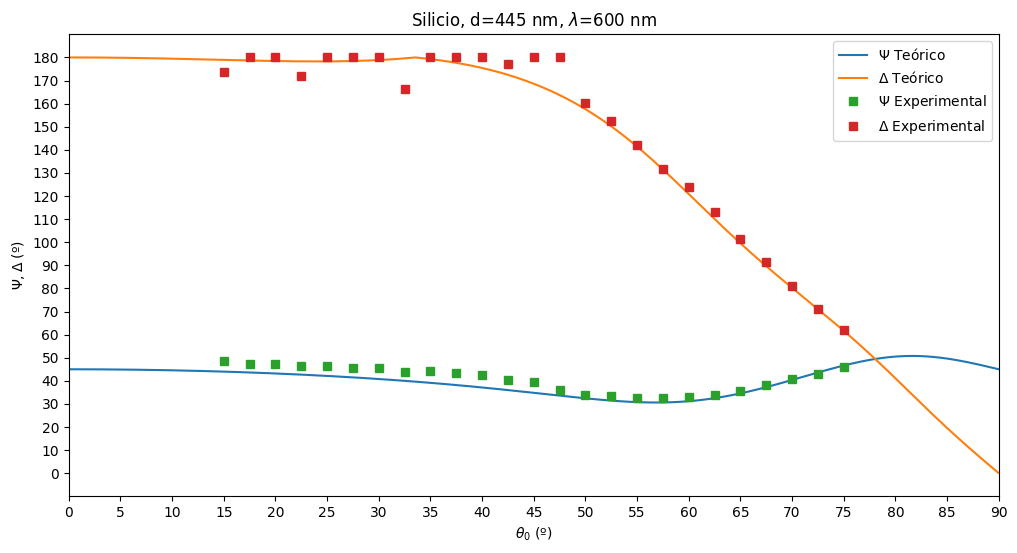

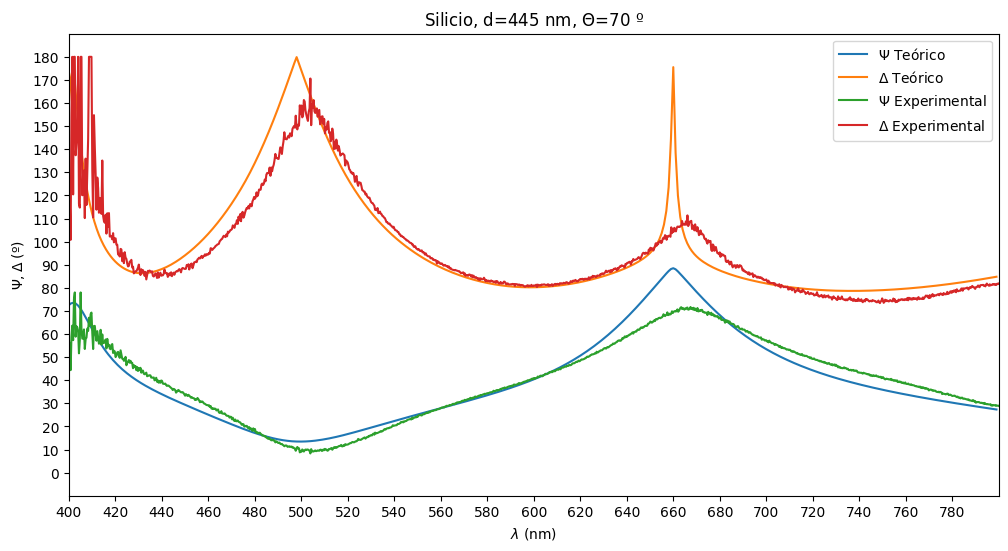

In [163]:
#Longitud de Onda
LongitudOnda = 600
AnguloIncidencia = 70
wl_min, wl_max = 400, 800

#Calculo Experimental
wl_range_experimental, theta_0_experimental, psi_experimental, delta_experimental, Rp_experimental, Rs_experimental = calculo_experimental(dataset_aire, dataset, angulo_calibracion_out = 12, angulo_incial = 15, angulo_final = 75, angulo_paso = angulo_paso, saturar = True)

#Calculo teórico
wl_range_teorico, theta_0_teorico, psi_teorico, delta_teorico, Rp_teorico, Rs_teorico = calculo_teorico(df_1, df_2, d, angulo_incial = 0, angulo_final = 90, angulo_paso = 0.05, wl_inicial = 300, wl_final = 800, wl_paso = 1)

#Plot angular
plot_angular(LongitudOnda, wl_range_teorico, wl_range_experimental, theta_0_teorico, theta_0_experimental, psi_teorico, delta_teorico, psi_experimental, delta_experimental, titulo, tipo = 'psi_delta', linestyle = '-', teorico = teorico, experimental = True)

#Plot espectral
plot_espectral(AnguloIncidencia, wl_range_teorico, wl_range_experimental, theta_0_teorico, theta_0_experimental, psi_teorico, delta_teorico, psi_experimental, delta_experimental, titulo, tipo = 'psi_delta', linestyle = '-', teorico = teorico, experimental = True)


# Reflectancia Silicio

In [160]:
#Parámetros Silicio
d = 445
titulo = 'Silicio'
df_O2Si = cargar_data(path_O2Si)
df_Si = cargar_data(path_Si)
dataset = dataset_silicio
angulo_paso = 2.5
df_1 = df_O2Si
df_2 = df_Si
teorico = True

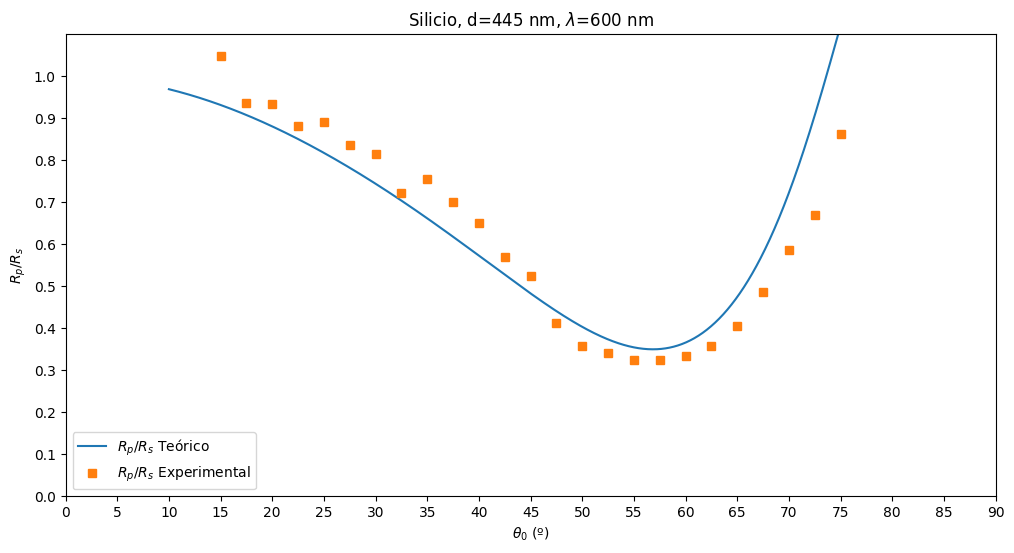

In [161]:
#Longitud de Onda
LongitudOnda = 600
wl_min, wl_max = 300, 900
i = int((AnguloIncidencia-15)/angulo_paso)

#Calculo Experimental
wl_range_experimental, theta_0_experimental, _, _, Rp_experimental, Rs_experimental = calculo_experimental(dataset_aire, dataset, angulo_calibracion_in = 12, angulo_calibracion_out = 12, angulo_incial = 15, angulo_final = 75, angulo_paso = angulo_paso, saturar = True)

#Calculo teórico
wl_range_teorico, theta_0_teorico, psi_teorico, delta_teorico, Rp_teorico, Rs_teorico = calculo_teorico(df_1, df_2, d, angulo_incial = 10, angulo_final = 80, angulo_paso = 0.05, wl_inicial = 300, wl_final = 900, wl_paso = 1)

#Numero de muestra
N_teorico = obtener_muestra(wl_range_teorico, LongitudOnda)
N_experimental = obtener_muestra(wl_range_experimental, LongitudOnda)

#Cocientes
cociente_t = Rp_teorico[:,N_teorico] / Rs_teorico[:,N_teorico]
cociente_p = Rp_experimental[:,N_experimental] / Rs_experimental[:,N_experimental]

# Plot psi and delta in degrees
plt.figure(figsize=(12, 6))
plt.plot(theta_0_teorico, cociente_t, label = r'$R_p/R_s$ Teórico')
plt.plot(theta_0_experimental, cociente_p, 's', label = r'$R_p/R_s$ Experimental')
plt.xlabel(r'$\theta_0$ (º)')
plt.ylabel(r'$R_p/R_s$')
plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\lambda$=' + str(LongitudOnda) + ' nm')
plt.xlim([0, 90])
plt.ylim([0, 1.1])
plt.xticks(np.arange(0,95,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()
plt.show()


# Reflectancia Vidrio

In [157]:
#Parámetros Vidrio
d = 2e6
titulo = 'Vidrio'
df_BK7 = cargar_data(path_BK7)
df_air = cargar_data(path_air)
dataset = dataset_vidrio
angulo_paso = 5
df_1 = df_BK7
df_2 = df_air
teorico = False
#Calibra cambios en la iluminacion
calibracion_exposicion = list(0.45*np.array([0.05,0.08,0.08,0.06,0.08,0.05,0.3,0.3,0.3,0.4,0.55,0.25,0.25]))

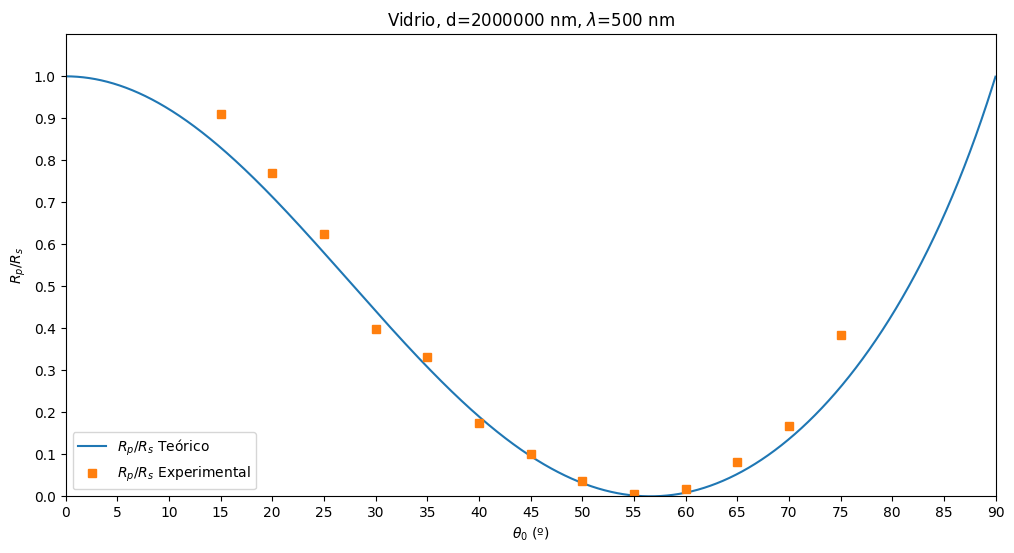

In [159]:
#Longitud de Onda
LongitudOnda = 500
wl_min, wl_max = 300, 900

#Calculo Experimental
wl_range_experimental, theta_0_experimental, _, _, Rp_experimental, Rs_experimental = calculo_experimental(dataset_aire, dataset, angulo_calibracion_in =12, angulo_calibracion_out = 12, angulo_incial = 15, angulo_final = 75, angulo_paso = angulo_paso, saturar = True)

#Longitud de onda
wl_range = np.arange(400, 800, 1)

#Angulo de incidencia
theta_0 = np.arange(0, 90, 0.01) * np.pi / 180

#Interpolación dataset
dataset_n1 = interpolar_dataframe(df_1, wl_inicial = 400, wl_final = 800)

#Cálculo de indices de refracción complejo
n0 = 1
n1_range = calcular_indice_refraccion(dataset_n1)

# Salida
Rp = np.zeros((len(theta_0), len(wl_range)))
Rs = np.zeros((len(theta_0), len(wl_range)))

#Para cada longitud de onda
for i, wl in enumerate(wl_range):

  #Indices de Refracción
  n1 = n1_range[i]

  #Angulos de refracción y transmisión
  sin_theta_0 = np.sin(theta_0)
  cos_theta_0 = np.cos(theta_0)
  sin_theta_1 = (n0/n1) * sin_theta_0
  cos_theta_1 = np.sqrt(1 - sin_theta_1**2)

  #Diferencia de fases
  beta = 2*np.pi/wl*d*n1*cos_theta_1

  #Indices de Reflectancia paralelo y perpendicular
  r01p = (n1*cos_theta_0 - n0*cos_theta_1) / (n1*cos_theta_0 + n0*cos_theta_1)
  r01s = (n0*cos_theta_0 - n1*cos_theta_1) / (n0*cos_theta_0 + n1*cos_theta_1)

  #Reflectancias total paralela y perpendicular
  Rp[:,i] = np.abs(r01p)**2
  Rs[:,i] = np.abs(r01s)**2

theta_0 = theta_0 * 180 / np.pi

#Numero de muestra
N_teorico = obtener_muestra(wl_range_teorico, LongitudOnda)
N_experimental = obtener_muestra(wl_range_experimental, LongitudOnda)

cociente_t = Rp[:,N_teorico] / Rs[:,N_teorico]
cociente_p = Rp_experimental[:,N_experimental] / Rs_experimental[:,N_experimental]

# Plot psi and delta in degrees
plt.figure(figsize=(12, 6))
plt.plot(theta_0, cociente_t, label = r'$R_p/R_s$ Teórico')
plt.plot(theta_0_experimental, cociente_p, 's', label = r'$R_p/R_s$ Experimental')

plt.xlabel(r'$\theta_0$ (º)')
plt.ylabel(r'$R_p/R_s$')
plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\lambda$=' + str(LongitudOnda) + ' nm')
plt.xlim([0, 90])
plt.ylim([0, 1.1])
plt.xticks(np.arange(0,95,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()
plt.show()

# Incertidumbre Silicio


In [152]:
#Parámetros Silicio
d = 445
titulo = 'Silicio'
df_O2Si = cargar_data(path_O2Si)
df_Si = cargar_data(path_Si)
dataset = dataset_silicio
angulo_paso = 2.5
df_1 = df_O2Si
df_2 = df_Si
teorico = True

In [153]:
#Longitud de Onda
LongitudOnda = 600
AnguloIncidencia = 70
wl_min, wl_max = 400, 800

#Calculo Experimental
wl_range_experimental, theta_0_experimental, psi_experimental, delta_experimental, Rp_experimental, Rs_experimental = calculo_experimental(dataset_aire, dataset, angulo_calibracion_out = 12, angulo_incial = 15, angulo_final = 75, angulo_paso = angulo_paso, saturar = True)

#Calculo teórico
wl_range_teorico, theta_0_teorico, psi_teorico, delta_teorico, Rp_teorico, Rs_teorico = calculo_teorico(df_1, df_2, d, angulo_incial = 0, angulo_final = 90, angulo_paso = 0.05, wl_inicial = 300, wl_final = 800, wl_paso = 1)
wl_range_teorico, theta_0_teorico, psi_teorico_mas, delta_teorico_mas, Rp_teorico_mas, Rs_teorico_mas = calculo_teorico(df_1, df_2, d+0.01*d, angulo_incial = 0, angulo_final = 90, angulo_paso = 0.05, wl_inicial = 300, wl_final = 800, wl_paso = 1)
wl_range_teorico, theta_0_teorico, psi_teorico_menos, delta_teorico_menos, Rp_teorico_menos, Rs_teorico_menos = calculo_teorico(df_1, df_2, d-0.01*d, angulo_incial = 0, angulo_final = 90, angulo_paso = 0.05, wl_inicial = 300, wl_final = 800, wl_paso = 1)


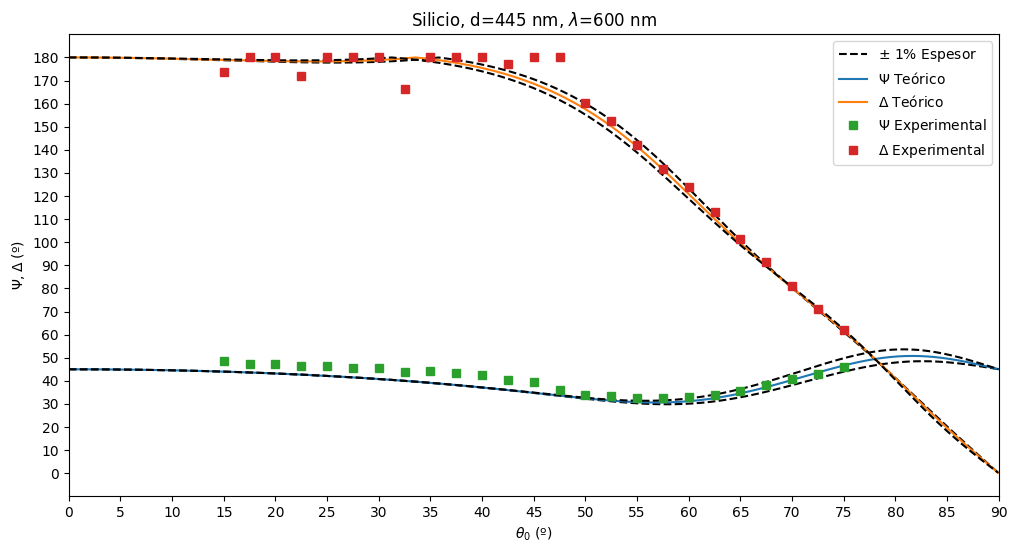

In [154]:
#Numero de muestra
N_teorico = obtener_muestra(wl_range_teorico, LongitudOnda)
N_experimental = obtener_muestra(wl_range_experimental, LongitudOnda)

# Plot psi and delta in degrees
plt.figure(figsize=(12, 6))
plt.plot(theta_0_teorico, psi_teorico_mas[:,N_teorico], linestyle = 'dashed', color = 'black', label = r'$\pm$ 1% Espesor')
plt.plot(theta_0_teorico, psi_teorico[:,N_teorico], linestyle = '-', label = r'$\Psi$ Teórico')
plt.plot(theta_0_teorico, psi_teorico_menos[:,N_teorico], linestyle = 'dashed', color = 'black')

plt.plot(theta_0_teorico, delta_teorico_mas[:,N_teorico] , linestyle = 'dashed', color = 'black')
plt.plot(theta_0_teorico, delta_teorico[:,N_teorico] , linestyle = '-', label = r'$\Delta$ Teórico')
plt.plot(theta_0_teorico, delta_teorico_menos[:,N_teorico] , linestyle = 'dashed', color = 'black')

plt.plot(theta_0_experimental, psi_experimental[:,N_experimental], 's', label = r'$\Psi$ Experimental')
plt.plot(theta_0_experimental, delta_experimental[:,N_experimental], 's', label = r'$\Delta$ Experimental')

plt.xlabel(r'$\theta_0$ (º)')
plt.ylabel(r'$\Psi, \Delta$ (º)')
plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\lambda$=' + str(LongitudOnda) + ' nm')
plt.xlim([0, 90])
plt.ylim([-10, 190])
plt.xticks(np.arange(0,95,5))
plt.yticks(np.arange(0,190,10))
plt.legend()
plt.show()


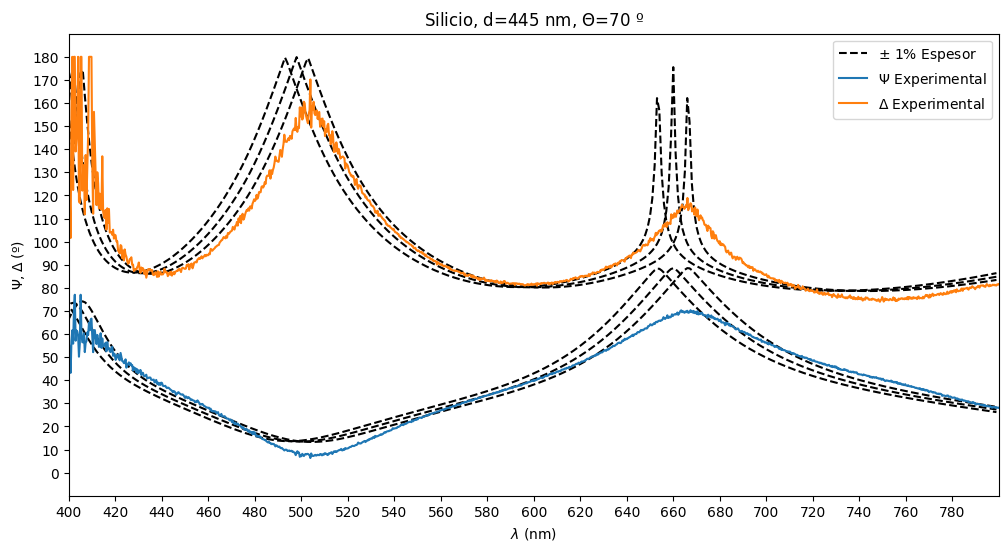

In [125]:
#Numero de muestra
N_teorico = obtener_muestra(theta_0_teorico, AnguloIncidencia)
N_experimental = obtener_muestra(theta_0_experimental, AnguloIncidencia)

# Plot psi and delta in degrees
plt.figure(figsize=(12, 6))

plt.plot(wl_range_teorico, psi_teorico_mas[N_teorico,:], linestyle = 'dashed', color = 'black', label = r'$\pm$ 1% Espesor')
plt.plot(wl_range_teorico, psi_teorico[N_teorico,:], linestyle = 'dashed', color = 'black')
plt.plot(wl_range_teorico, psi_teorico_menos[N_teorico,:], linestyle = 'dashed', color = 'black')

plt.plot(wl_range_teorico, delta_teorico_mas[N_teorico,:], linestyle = 'dashed', color = 'black')
plt.plot(wl_range_teorico, delta_teorico[N_teorico,:], linestyle = 'dashed', color = 'black')
plt.plot(wl_range_teorico, delta_teorico_menos[N_teorico,:], linestyle = 'dashed', color = 'black')

plt.plot(wl_range_experimental, psi_experimental[N_experimental,:], '', label = r'$\Psi$ Experimental')
plt.plot(wl_range_experimental, delta_experimental[N_experimental,:], '', label = r'$\Delta$ Experimental')

plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\Psi, \Delta$ (º)')
plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\Theta$=' + str(AnguloIncidencia) + ' º')
plt.xlim([wl_min, wl_max])
plt.ylim([-10, 190])
plt.xticks(np.arange(wl_min,wl_max,int((wl_max-wl_min)/20)))
plt.yticks(np.arange(0,190,10))
plt.legend()
plt.show()

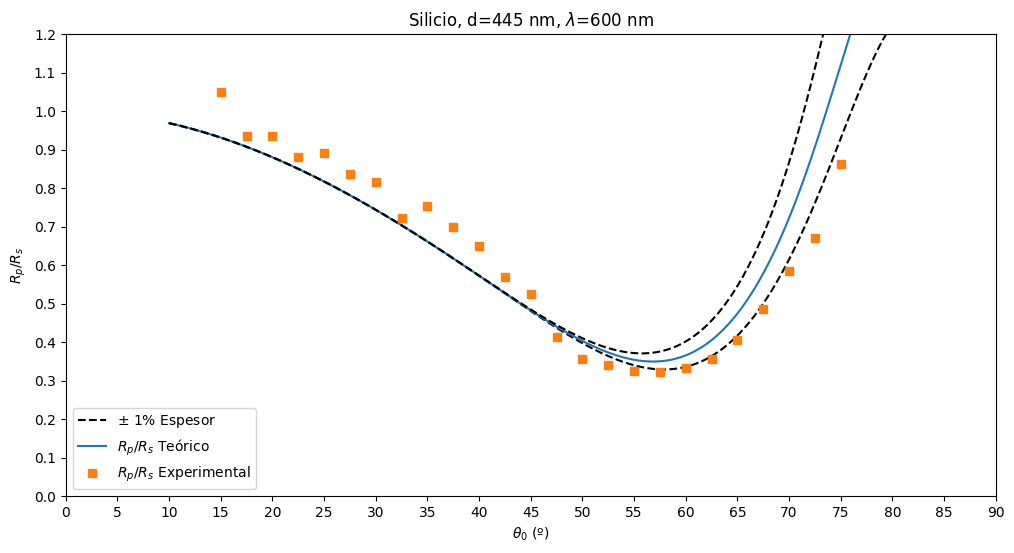

In [172]:
#Longitud de Onda
LongitudOnda = 600
wl_min, wl_max = 300, 900
i = int((AnguloIncidencia-15)/angulo_paso)

#Calculo Experimental
wl_range_experimental, theta_0_experimental, _, _, Rp_experimental, Rs_experimental = calculo_experimental(dataset_aire, dataset, angulo_calibracion_in = 12, angulo_calibracion_out = 12, angulo_incial = 15, angulo_final = 75, angulo_paso = angulo_paso, saturar = True)

#Calculo teórico
wl_range_teorico, theta_0_teorico, _, _, Rp_teorico_mas, Rs_teorico_mas = calculo_teorico(df_1, df_2, d+0.01*d, angulo_incial = 10, angulo_final = 80, angulo_paso = 0.05, wl_inicial = 300, wl_final = 900, wl_paso = 1)
wl_range_teorico, theta_0_teorico, _, _, Rp_teorico, Rs_teorico = calculo_teorico(df_1, df_2, d, angulo_incial = 10, angulo_final = 80, angulo_paso = 0.05, wl_inicial = 300, wl_final = 900, wl_paso = 1)
wl_range_teorico, theta_0_teorico, _, _, Rp_teorico_menos, Rs_teorico_menos = calculo_teorico(df_1, df_2, d-0.01*d, angulo_incial = 10, angulo_final = 80, angulo_paso = 0.05, wl_inicial = 300, wl_final = 900, wl_paso = 1)

#Numero de muestra
N_teorico = obtener_muestra(wl_range_teorico, LongitudOnda)
N_experimental = obtener_muestra(wl_range_experimental, LongitudOnda)

#Cocientes
cociente_t_mas = Rp_teorico_mas[:,N_teorico] / Rs_teorico_mas[:,N_teorico]
cociente_t = Rp_teorico[:,N_teorico] / Rs_teorico[:,N_teorico]
cociente_t_menos = Rp_teorico_menos[:,N_teorico] / Rs_teorico_menos[:,N_teorico]

cociente_p = Rp_experimental[:,N_experimental] / Rs_experimental[:,N_experimental]

# Plot psi and delta in degrees
plt.figure(figsize=(12, 6))
plt.plot(theta_0_teorico, cociente_t_mas, linestyle = 'dashed', color = 'black', label = r'$\pm$ 1% Espesor')
plt.plot(theta_0_teorico, cociente_t, label = r'$R_p/R_s$ Teórico')
plt.plot(theta_0_teorico, cociente_t_menos, linestyle = 'dashed', color = 'black')
plt.plot(theta_0_experimental, cociente_p, 's', label = r'$R_p/R_s$ Experimental')
plt.xlabel(r'$\theta_0$ (º)')
plt.ylabel(r'$R_p/R_s$')
plt.title(titulo + ', d=' + str(int(d)) + ' nm' + ', $\lambda$=' + str(LongitudOnda) + ' nm')
plt.xlim([0, 90])
plt.ylim([0, 1.2])
plt.xticks(np.arange(0,95,5))
plt.yticks(np.arange(0,1.3,0.1))
plt.legend()
plt.show()
